In [1]:
# Core libraries
import os
import sys
import gc
import re
import csv
import time
import logging
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Statistical and mathematical libraries
from scipy.stats import spearmanr, median_abs_deviation
from scipy.cluster import hierarchy
from scipy.spatial.distance import squareform
from scipy.integrate import fixed_quad
from scipy.special import gammaln, betaln, digamma, polygamma
from scipy.optimize import fmin
from scipy.stats import f_oneway
from statsmodels.stats.multicomp import pairwise_tukeyhsd

# Machine learning libraries
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import (
    StratifiedKFold,
    RepeatedStratifiedKFold,
    cross_val_predict,
    train_test_split,
    cross_val_score,
    GridSearchCV,
)
from sklearn.metrics import (
    classification_report,
    accuracy_score,
    confusion_matrix,
)
from sklearn.ensemble import (
    RandomForestClassifier,
    HistGradientBoostingClassifier,
)
from sklearn.svm import SVC, LinearSVC
from sklearn.linear_model import SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.manifold import TSNE
from sklearn.inspection import permutation_importance
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import IsolationForest
from sklearn.decomposition import PCA

# Visualization
from matplotlib.patches import Patch
import plotly.graph_objects as go
import shap
import tqdm
from tqdm import tqdm

# Cytometry and single-cell libraries
import polars as pl
import pycytominer as pm
import scanpy as sc
import anndata as ad

# Saving model
import joblib
from joblib import dump
from joblib import load

In [2]:
class RobustMAD(BaseEstimator, TransformerMixin):
    """Class to perform a "Robust" normalization with respect to median and mad."""

    def __init__(self, epsilon=1e-18):
        self.epsilon = epsilon

    def fit(self, X, y=None):
        """Compute the median and mad to be used for later scaling."""
        self.median = X.median()
        self.mad = pd.Series(
            median_abs_deviation(X, nan_policy="omit", scale=1 / 1.4826),
            index=self.median.index,
        )
        return self

    def transform(self, X):
        """Apply the RobustMAD scaling."""
        return (X - self.median) / (self.mad + self.epsilon)

def normalize_pl(profiles, features, meta_features, method="robustize"):
    """
    Normalizes a Pandas DataFrame using the specified scaling method.
    
    Parameters:
    - profiles: Pandas DataFrame containing data to normalize.
    - features: List of feature columns.
    - meta_features: List of metadata columns.
    - method: Normalization method ("standardize", "robustize", or "mad_robustize").
    
    Returns:
    - A normalized Pandas DataFrame.
    """
    method = method.lower()
    if method == "standardize":
        scaler = StandardScaler()
    elif method == "robustize":
        scaler = RobustScaler()
    elif method == "mad_robustize":
        scaler = RobustMAD()

    feature_data = profiles[features]
    meta_df = profiles[meta_features]

    scaled_features = pd.DataFrame(
        scaler.fit_transform(feature_data),
        columns=features,
        index=profiles.index,
    )

    return pd.concat([meta_df, scaled_features], axis=1)

def prep_data(plate_df, features, meta_features):
    """
    Preprocess and normalize data from a single plate by dropping NaNs and normalizing.

    Parameters:
    - plate_df: Pandas DataFrame for the plate.
    - features: List of feature columns to process.
    - meta_features: List of metadata columns.

    Returns:
    - Normalized DataFrame with NaNs dropped from feature columns.
    """
    def preprocess_single_plate(df, features, meta_features):
        print(f"Before NA filtering: {df.shape}")
        
        # Drop rows with NaN in the feature columns
        df_filt = df.dropna(subset=features)
        print(f"After NA filtering: {df_filt.shape}")
        
        # Normalize the data
        data_norm = normalize_pl(
            profiles=df_filt,
            features=features,
            meta_features=meta_features,
            method="robustize"
        )
        print("Normalization complete.")
        return data_norm

    print("Preprocessing and normalizing single plate...")
    processed_plate = preprocess_single_plate(plate_df, features, meta_features)
    
    print("Preprocessing complete.")
    return processed_plate

def add_suffix_to_column_names(df, suffix):
    """
    Adds a suffix and underscore to all column names in the Pandas DataFrame.

    Parameters:
    df (pd.DataFrame): The original Pandas DataFrame.
    suffix (str): The suffix string to add to each column name.

    Returns:
    pd.DataFrame: A new DataFrame with updated column names.
    """
    df = df.rename(columns={col: f"{col}_{suffix}" for col in df.columns})
    return df

def aggregate_dataframe(df, function='median'):
    """
    Aggregates a Pandas DataFrame using the specified function ('median' or 'mean').

    Parameters:
    - df (pd.DataFrame): Input DataFrame.
    - function (str): Aggregation function ('median' or 'mean').

    Returns:
    - pd.DataFrame: Aggregated DataFrame.
    """
    grouping_columns = ["Metadata_Condition_nuclei", "Metadata_Plate_nuclei", "Metadata_Site_nuclei", "Metadata_Well_nuclei", "Metadata_Celline_nuclei"]

    numeric_columns = [col for col in df.select_dtypes(include='number').columns if col not in grouping_columns]

    if function == 'median':
        agg_df = df.groupby(grouping_columns)[numeric_columns].median().reset_index()
    elif function == 'mean':
        agg_df = df.groupby(grouping_columns)[numeric_columns].mean().reset_index()
    else:
        raise ValueError(f"Unsupported aggregation function: {function}")

    return agg_df

def load_feature_data(plate):
    nuclei_feats = pd.read_csv(f"{plate}cell_FilteredNuclei.csv")
    cyto_feats = pd.read_csv(f"{plate}cell_Cytoplasm.csv")
    cell_feats = pd.read_csv(f"{plate}cell_Cells.csv")

    nuclei_feats = add_suffix_to_column_names(nuclei_feats, "nuclei")
    cyto_feats = add_suffix_to_column_names(cyto_feats, "cytoplasm")
    cell_feats = add_suffix_to_column_names(cell_feats, "cells")

    df = pd.concat([nuclei_feats, cell_feats, cyto_feats], axis=1)
    return df

def is_meta_column(c):
    for ex in '''
        Metadata
        ^Count
        ImageNumber
        Object
        Parent
        Children
        Plate
        Well
        Celline
        location
        Location
        _[XYZ]_
        _[XYZ]$
        Phase
        Scale
        Scaling
        Width
        Height
        Group
        FileName
        PathName
        BoundingBox
        URL
        Execution
        ModuleError
        LargeBrightArtefact
        AreaShape_NormalizedMoment_0_0
        AreaShape_NormalizedMoment_0_1
        AreaShape_NormalizedMoment_1_0
        Unnamed
    '''.split():
        if re.search(ex, c):
            return True
    return False

In [18]:
cp_feats_CP0XX = load_feature_data("CP020")

In [19]:
cp_feats_CP0XX_agg = aggregate_dataframe(cp_feats_CP0XX)

C:\Users\Pathology\AppData\Local\Temp\ipykernel_8024\2386248396.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agg_df = df.groupby(grouping_columns)[numeric_columns].median().reset_index()
C:\Users\Pathology\AppData\Local\Temp\ipykernel_8024\2386248396.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agg_df = df.groupby(grouping_columns)[numeric_columns].median().reset_index()
C:\Users\Pathology\AppData\Local\Temp\ipykernel_8024\2386248396.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually t

In [20]:
metadata_columns = [col for col in cp_feats_CP0XX_agg.columns if is_meta_column(col)]
feature_columns = [col for col in cp_feats_CP0XX_agg.columns if col not in metadata_columns]

In [21]:
df1_norm_agg = prep_data(cp_feats_CP0XX_agg, feature_columns, metadata_columns)

Preprocessing and normalizing single plate...
Before NA filtering: (540, 2630)
After NA filtering: (540, 2630)
Normalization complete.
Preprocessing complete.


In [22]:
# Load the model tuple from the file
filename = 'E:/CellPROFILER/MODEL/Modelrobustize.cpamodel'
model_tuple = joblib.load(filename)

# Extract the components from the tuple
gb_clf_final, class_names, model_class_name, feature_names = model_tuple

In [23]:
# Extract only the features needed for the model
model_features = [col for col in feature_columns if col in feature_names]

# Combine metadata and model features
columns_to_keep = metadata_columns + model_features

# Filter the dataset
df1_filtered = df1_norm_agg[columns_to_keep]

# Debug output
print(f"Number of metadata features: {len(metadata_columns)}")
print(f"Number of model features: {len(model_features)}")
print(f"Total columns in filtered dataset: {len(columns_to_keep)}")

Number of metadata features: 161
Number of model features: 15
Total columns in filtered dataset: 176


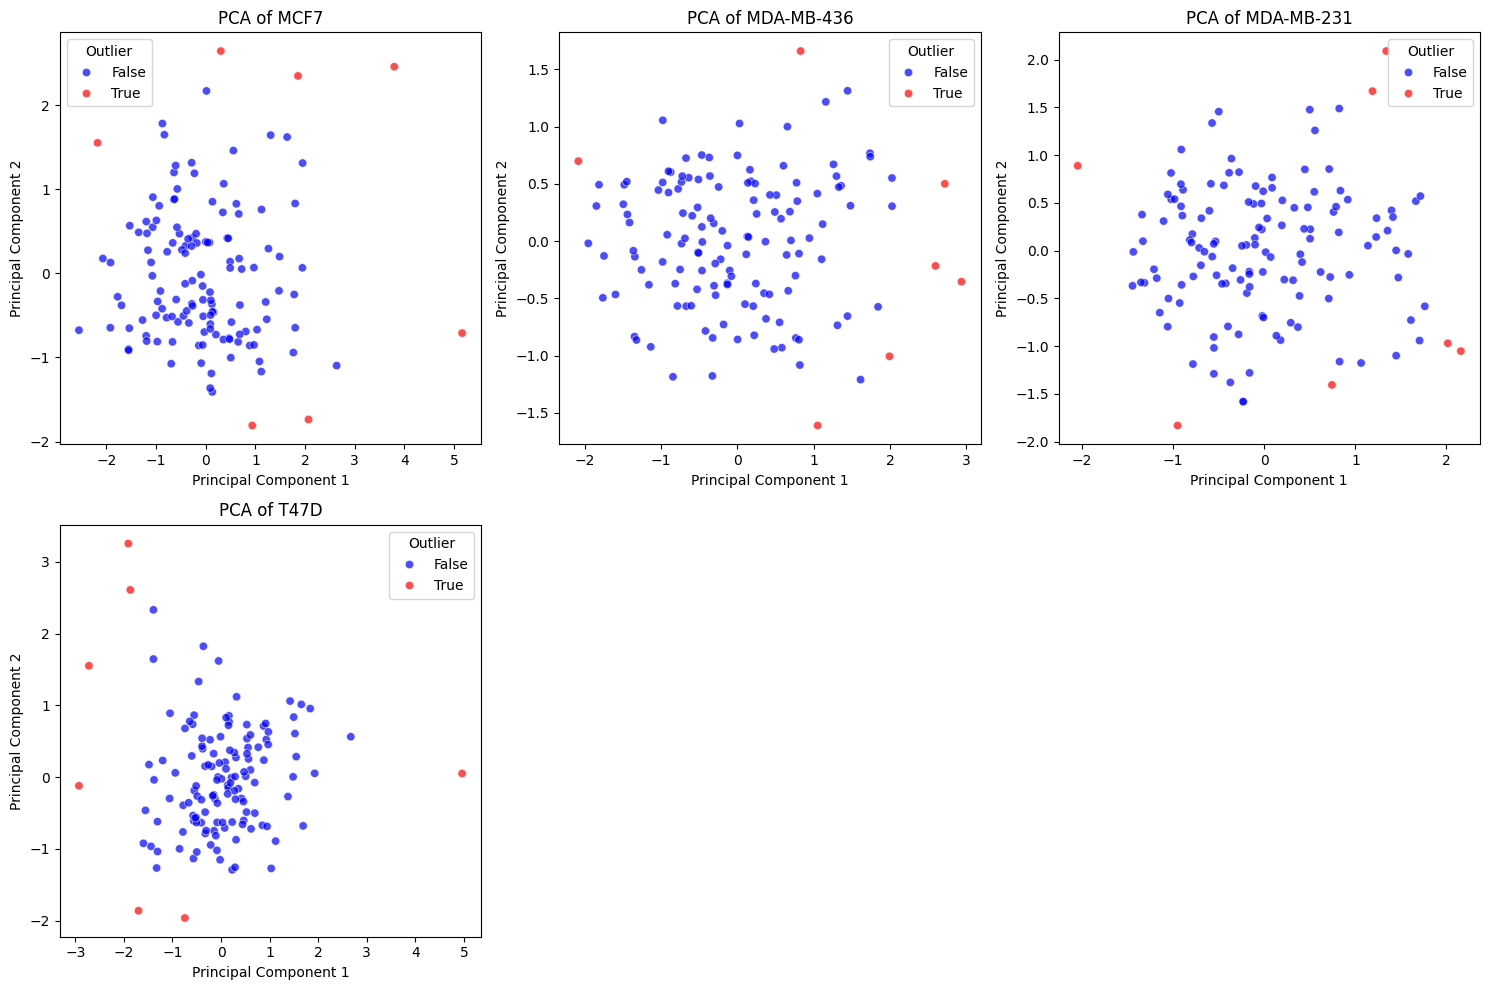

In [24]:
# Metadata and feature columns
feature_columns = [col for col in df1_filtered.columns if not is_meta_column(col)]

# Extract unique conditions from Metadata_Condition_nuclei
conditions = df1_filtered['Metadata_Celline_nuclei'].unique()

# Set up the figure and axes for subplots
n_conditions = len(conditions)
fig, axes = plt.subplots(nrows=(n_conditions + 2) // 3, ncols=3, figsize=(15, (n_conditions + 2) // 3 * 5))
axes = axes.flatten()

# Dictionary to store outliers for each condition
condition_outliers = {}

# Perform PCA and outlier detection per condition
for i, condition in enumerate(conditions):
    ax = axes[i]

    # Filter data for the current condition
    condition_df = df1_filtered[df1_filtered['Metadata_Celline_nuclei'] == condition]

    # Extract feature data
    features = condition_df[feature_columns]

    # Perform PCA
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(features)

    # Initialize Isolation Forest for outlier detection
    isolation_forest = IsolationForest(random_state=42, contamination=0.05, n_jobs=-1)  # Adjust contamination if needed, expect around 5%
    outliers = isolation_forest.fit_predict(X_pca)

    # Create a PCA DataFrame
    pca_df = pd.DataFrame(data=X_pca, columns=['PC1', 'PC2'], index=condition_df.index)
    pca_df['outlier'] = outliers == -1

    # Store outlier information for the current condition
    condition_outliers[condition] = pca_df[pca_df['outlier'] == True]

    # Plot PCA results for the current condition
    sns.scatterplot(
        data=pca_df,
        x='PC1',
        y='PC2',
        hue='outlier',
        palette={False: 'blue', True: 'red'},
        alpha=0.7,
        ax=ax
    )

    # Add plot details
    ax.set_title(f'PCA of {condition}')
    ax.set_xlabel('Principal Component 1')
    ax.set_ylabel('Principal Component 2')
    ax.legend(title='Outlier', loc='best')

# Hide unused axes if the number of conditions doesn't fill the grid
for j in range(i + 1, len(axes)):
    axes[j].axis('off')

# Adjust layout
plt.tight_layout()
plt.show()


In [25]:
# Create a set to store all indices of outliers across all conditions
outlier_indices = set()

# Collect all outlier indices from the condition_outliers dictionary
for condition, outliers_df in condition_outliers.items():
    outlier_indices.update(outliers_df.index)

# Filter out the outliers from df1_filtered
df1_filtered_no_outliers = df1_filtered[~df1_filtered.index.isin(outlier_indices)]

# Display the filtered DataFrame without outliers
print(f"Original dataframe size: {df1_filtered.shape}")
print(f"Filtered dataframe size (no outliers): {df1_filtered_no_outliers.shape}")

Original dataframe size: (540, 176)
Filtered dataframe size (no outliers): (512, 176)


In [26]:
# Ensure the DataFrame contains only the feature columns for prediction
features_for_prediction = df1_filtered_no_outliers[feature_names]

# Calculate probabilities using the model
probabilities = gb_clf_final.predict_proba(features_for_prediction)

# Convert probabilities to a DataFrame
probabilities_df = pd.DataFrame(probabilities, columns=class_names, index=df1_filtered_no_outliers.index)

# Select only the relevant metadata columns (e.g., 'Metadata_Condition' and 'Metadata_Well')
metadata_columns = ['Metadata_Celline_nuclei', 'Metadata_Well_nuclei']  # Replace with the actual column names in your dataset
metadata_df = df1_filtered_no_outliers[metadata_columns]

# Combine metadata with probabilities
final_probabilities_df = pd.concat([metadata_df, probabilities_df], axis=1)

# Display the probabilities DataFrame
final_probabilities_df.to_csv('calculated_probabilities_celline_well_CP020.csv', index=False)

final_probabilities_df

,Metadata_Celline_nuclei,Metadata_Well_nuclei,24h TGFb1,48h TGFb1,4d TGFb1,8d TGFb1,Control
1,MCF7,B03,1.526383e-06,0.000002,0.000024,8.546551e-07,0.999972
2,MCF7,B04,6.529142e-03,0.002790,0.952606,2.881155e-03,0.035194
3,MCF7,B05,8.867901e-06,0.031200,0.968772,4.913088e-06,0.000014
4,MCF7,B06,3.032893e-03,0.015480,0.966991,1.132871e-03,0.013362
5,MDA-MB-436,B07,9.887491e-07,0.008107,0.000246,9.916444e-01,0.000002
...,...,...,...,...,...,...,...
535,MDA-MB-436,G07,3.699727e-07,0.002459,0.000062,9.974771e-01,0.000001
536,MDA-MB-436,G08,9.987482e-06,0.540369,0.002204,4.574034e-01,0.000013
537,MDA-MB-436,G09,6.827087e-06,0.932410,0.015960,5.161137e-02,0.000012
538,MDA-MB-436,G10,1.126644e-05,0.082618,0.085189,8.321735e-01,0.000008


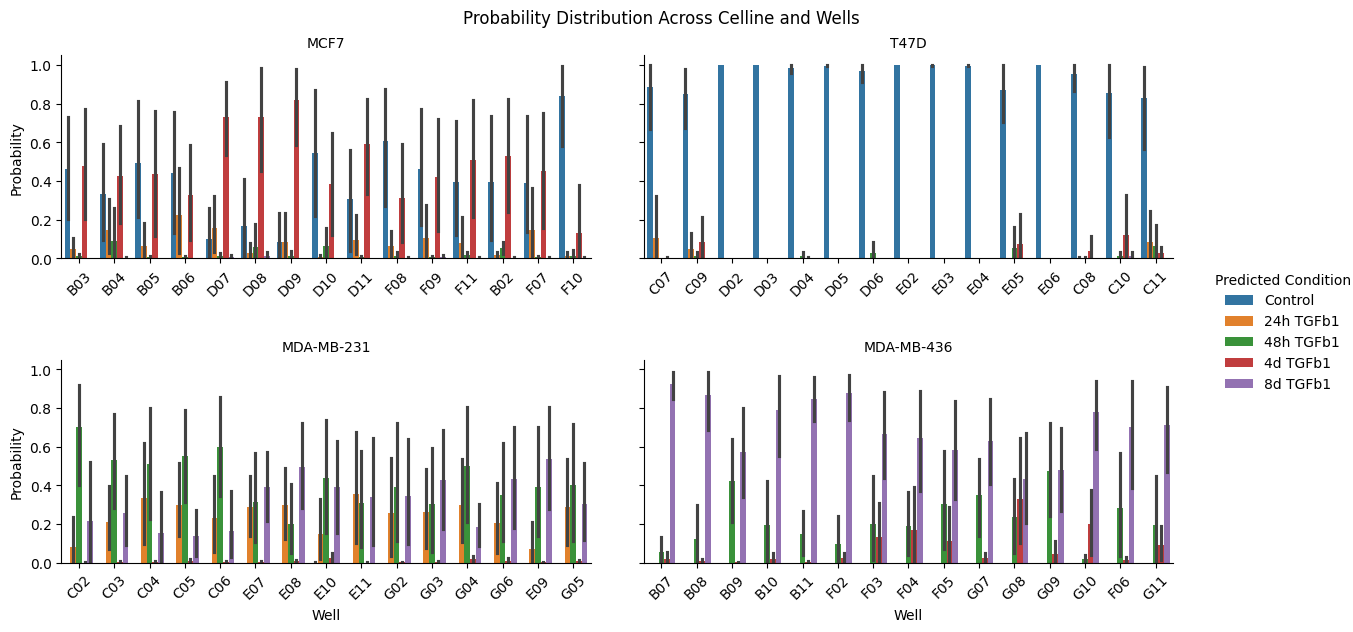

In [27]:
# Melting the DataFrame to long format
probabilities_long = pd.melt(final_probabilities_df.reset_index(), 
                             id_vars=['Metadata_Well_nuclei', 'Metadata_Celline_nuclei'], 
                             var_name='Predicted_Condition', 
                             value_name='Probability')

# Define the desired order for Predicted_Condition and Metadata_Condition_nuclei
predicted_condition_order = ['Control', '24h TGFb1', '48h TGFb1', '4d TGFb1', '8d TGFb1']  # Use the class names directly from the model
metadata_condition_order = ['MCF7', 'T47D', 'MDA-MB-231', 'MDA-MB-436']  # Adjust as per your dataset

# Adjusting the catplot layout for better visibility
g = sns.catplot(data=probabilities_long, 
                x='Metadata_Well_nuclei', 
                y='Probability', 
                hue='Predicted_Condition', 
                col='Metadata_Celline_nuclei', 
                kind='bar', 
                col_wrap=2,  # Display one condition per row for better visibility
                height=3,  # Increase plot height
                aspect=2,  # Increase aspect ratio for wider bars
                sharex=False,
                hue_order=predicted_condition_order,  # Order of the predicted conditions
                col_order=metadata_condition_order)  # Order of metadata conditions

# Set titles and labels
g.set_titles("{col_name}")
g.set_axis_labels("Well", "Probability")
g.set_xticklabels(rotation=45, fontsize=10)  # Rotate and adjust font size for well labels

# Add a main title
g.fig.suptitle('Probability Distribution Across Celline and Wells', y=1.02)  # Adjust y for spacing

# Change the legend title
g._legend.set_title('Predicted Condition')

# Adjust the legend position
g._legend.set_bbox_to_anchor((1.01, 0.5))  # Place the legend outside the plot

# Further adjust subplot and legend spacing
g.fig.subplots_adjust(wspace=0.1, hspace=0.5)  # Increase spacing for better readability

plt.show()


In [28]:
file_path = 'E:/CELLPROFILER/OUTPUT MODEL/Probability_distribution_CP020.png'
g.savefig(file_path, bbox_inches='tight', dpi=300)

In [29]:
# Define scores for each condition, assuming progression towards EMT
condition_scores = {
    'Control': 1,
    '24h TGFb1': 2.92,
    '48h TGFb1': 4.39,
    '4d TGFb1': 4.92,
    '8d TGFb1': 6.07
}

# Function to calculate the EMT score for each row based on probabilities
def calculate_emt_score(row):
    # Calculate the weighted sum of probabilities and condition scores
    return sum(row[condition] * condition_score for condition, condition_score in condition_scores.items())

# Ensure the columns used for the calculation are only the conditions
# Exclude any metadata columns like 'Metadata_Condition_nuclei' or 'Metadata_Well_nuclei'
condition_columns = [col for col in probabilities_long['Predicted_Condition'].unique() if col in condition_scores]

# Pivot the melted DataFrame back to a wide format for easier calculation
probabilities_wide = probabilities_long.pivot_table(
    index=['Metadata_Well_nuclei', 'Metadata_Celline_nuclei'],
    columns='Predicted_Condition',
    values='Probability'
).reset_index()

# Calculate EMT scores by applying the function row-wise
probabilities_wide['EMT_Score'] = probabilities_wide[condition_columns].apply(calculate_emt_score, axis=1)

# Display the calculated EMT scores along with metadata for context
print(probabilities_wide[['Metadata_Well_nuclei', 'Metadata_Celline_nuclei', 'EMT_Score']])

# Optionally save the results to a file
probabilities_wide.to_csv('emt_scores_CP020.csv', index=False)



Predicted_Condition Metadata_Well_nuclei Metadata_Celline_nuclei  EMT_Score
0                                    B02                    MCF7   3.313095
1                                    B03                    MCF7   3.013807
2                                    B04                    MCF7   3.283148
3                                    B05                    MCF7   2.861976
4                                    B06                    MCF7   2.730120
5                                    B07              MDA-MB-436   5.953772
6                                    B08              MDA-MB-436   5.850880
7                                    B09              MDA-MB-436   5.356391
8                                    B10              MDA-MB-436   5.722355
9                                    B11              MDA-MB-436   5.818793
10                                   C02              MDA-MB-231   4.635854
11                                   C03              MDA-MB-231   4.514135
12          

In [ ]:
# Create the figure
plt.figure(figsize=(16, 12))

# Create the boxplot
sns.boxplot(
    x='Metadata_Celline_nuclei', 
    y='EMT_Score', 
    data=probabilities_wide, 
    hue='Metadata_Celline_nuclei',  # Set x variable to hue
    palette="viridis",  # Keep the palette
    order=metadata_condition_order,
    dodge=False,  # Ensures no visual shift since hue is same as x
    legend=False  # Removes redundant legend
)

# Overlay a swarm plot to show all data points
sns.swarmplot(
    x='Metadata_Celline_nuclei', 
    y='EMT_Score', 
    data=probabilities_wide, 
    color=".25", 
    order=metadata_condition_order
)

# Add titles and labels
plt.title('Distribution of Predicted EMT Scores for Breast cancer baseline experiment (CP020)')
plt.xlabel('CellLine')
plt.ylabel('EMT Score')
plt.xticks(rotation=45)

# Perform Tukey's HSD for all pairwise comparisons
tukey_results = pairwise_tukeyhsd(
    probabilities_wide['EMT_Score'], 
    probabilities_wide['Metadata_Celline_nuclei']
)

# Convert Tukey's HSD results to a DataFrame for easier handling
tukey_summary = pd.DataFrame(
    data=tukey_results._results_table.data[1:], 
    columns=tukey_results._results_table.data[0]
)

# Determine the positions of the boxplot categories for annotation
positions = {condition: i for i, condition in enumerate(metadata_condition_order)}

# Define the maximum y-value and increment for annotation positioning
max_y = probabilities_wide['EMT_Score'].max() + (probabilities_wide['EMT_Score'].max() * 0.005)
increment = max_y * 0.02

# Annotate the plot with Tukey's HSD results
for index, row in tukey_summary.iterrows():
    if row['reject']:  # Only annotate significant comparisons
        # Get x positions for the two groups
        x1 = positions[row['group1']]
        x2 = positions[row['group2']]
        
        # Set the height for the annotation line
        height = max_y + (index * increment)
        
        # Draw the annotation line
        plt.plot([x1, x1, x2, x2], [height, height + increment / 2, height + increment / 2, height], lw=1.5, c='black')
        
        # Add the p-value as text
        p_value_text = f"p-adj = {row['p-adj']:.3f}"
        plt.text((x1 + x2) * 0.5, height + increment, p_value_text, ha='center', va='bottom', color='black')

        # Update max_y to prevent overlapping annotations
        max_y = max(max_y, height + increment)

# Remove the hue legend since it duplicates x-axis information
plt.legend([],[], frameon=False)

# Adjust layout and spacing
plt.tight_layout()
plt.subplots_adjust(top=0.9)

# Specify the file path where you want to save the figure
file_path = 'E:/CELLPROFILER/OUTPUT MODEL/EMT_scores_CP020.png'

# Save the figure to the specified path
plt.savefig(file_path, dpi=300, bbox_inches='tight')

# Show the plot
plt.show()

In [17]:
tukey_summary

,group1,group2,meandiff,p-adj,lower,upper,reject
0,24h TGFb1,48h TGFb1,1.5303,0.0,1.3806,1.6799,True
1,24h TGFb1,4d TGFb1,2.4976,0.0,2.3479,2.6472,True
2,24h TGFb1,8d TGFb1,2.8923,0.0,2.7557,3.0290,True
3,24h TGFb1,Control,-1.9200,0.0,-2.0566,-1.7834,True
4,48h TGFb1,4d TGFb1,0.9673,0.0,0.8176,1.1170,True
5,48h TGFb1,8d TGFb1,1.3621,0.0,1.2254,1.4987,True
6,48h TGFb1,Control,-3.4503,0.0,-3.5869,-3.3136,True
7,4d TGFb1,8d TGFb1,0.3948,0.0,0.2581,0.5314,True
8,4d TGFb1,Control,-4.4176,0.0,-4.5542,-4.2809,True
9,8d TGFb1,Control,-4.8123,0.0,-4.9345,-4.6901,True


In [12]:
from numpy import *

def lnchoose(n, m):
    nf = gammaln(n + 1)
    mf = gammaln(m + 1)
    nmmnf = gammaln(n - m + 1)
    return nf - (mf + nmmnf)


def logP(alpha, counts):
    alphasum = sum(alpha)
    def logPsingle(c):
        return gammaln(alphasum) - gammaln(alphasum + sum(c)) + sum([gammaln(alpha[k] + c[k]) - gammaln(alpha[k]) for k in range(len(alpha))])
    return sum([logPsingle(counts[i, :]) for i in range(counts.shape[0])])

def dirichlet_moment_match(proportions, weights):
    a = array(average(proportions, axis=0, weights=weights.flat))
    m2 = array(average(multiply(proportions, proportions), axis=0, weights=weights.flat))
    nz = (a > 0)
    aok = a[nz]
    m2ok = m2[nz]
    s = median((aok - m2ok) / (m2ok - aok * aok))
    return matrix(a * s)
    


def polya_moment_match(counts):
    return dirichlet_moment_match(array(counts) / sum(counts, axis=1).repeat(counts.shape[1], axis=1), sum(counts, axis=1))

def fit_betabinom_minka(counts, maxiter=1000, tol=1e-6, initial_guess=None):
    ''' See Estimating a Dirichlet Distribution, Thomas P. Minka, 2003,
    eq. 55.  see also the code for polya_fit_simple.m in his fastfit
    matlab toolbox, which this code is a translation of.

    counts should be NxK with N samples over K classes.'''

    counts = matrix(counts).astype(float)
    
    # remove observations with no trials
    counts = counts[sum(counts.A, axis=1) > 0, :]
    if initial_guess == None:
        alpha = polya_moment_match(counts).T
    else:
        alpha = matrix(initial_guess).T

    # Abstraction barrier: now in Dirichlet/Polya mode, following naming in Minka's paper.
    n = counts.T
    N = n.shape[1]
    n_i = n.sum(axis=0)

    change = 2*tol
    iter = 0
    while (change > tol) and (iter < maxiter):
        numerator = digamma(n + alpha.repeat(N, axis=1)).sum(axis=1) - N * digamma(alpha)
        denominator = digamma(n_i + alpha.sum()).sum() - N * digamma(alpha.sum())
        old_alpha = alpha
        alpha = multiply(alpha, numerator / denominator)
        change = abs(old_alpha - alpha).max()
        iter = iter + 1

    # now leaving Abstraction Barrier

    return array(alpha[:,0]).T, iter < maxiter

def di_pochhammer(x, n):
    'digamma(x+n) - digamma(x), but 0 for n = 0'
    y = zeros(n.shape)
    nz = (n > 0)
    y[nz] = digamma(x + n[nz]) - digamma(x)
    return y

def trigamma(x):
    return polygamma(1, x)

def tri_pochhammer(x, n):
    'trigamma(x+n) - trigamma(x), but 0 for n = 0'
    y = zeros(n.shape)
    nz = (n > 0)
    y[nz] = trigamma(x + n[nz]) - trigamma(x)
    return y
    
    

def polya_fit_m(counts, alpha, tol):
    '''see polya_fit_m.m in fastfit toolbox,
    and equation (118) fot Minka, 2003.'''
    s = sum(alpha)
    m = alpha / s
    N, K = counts.shape
    for iter in range(20):
        old_m = m.copy()
        a = s * m
        for k in range(K):
            dk = counts[:, k]
            vdk = a[k] * di_pochhammer(a[k], dk)
            m[k] = sum(vdk)
        m =  m / sum(m)
        if abs(m - old_m).max() < tol:
            break
    return s * m

def quad_root(a, b, c):
    '''roots of a^2 x + b x + c'''
    top = sqrt(b**2 - 4*a*c)
    return max(((-b + top) / (2 * a), (-b - top) / (2 * a)))

def polya_fit_s(counts, alpha, tol):
    '''see polya_fit_s.m in fastfit toolbox.  This implements section
    4.2 from Minka, 2003.  I've tried to translate it into the symbols
    of the paper.'''
    s = sum(alpha)
    m = alpha / s
    N, K = counts.shape
    scounts = sum(counts, axis=1)

    def s_derivatives(alpha_temp):
        s = sum(alpha_temp)
        m = alpha_temp / s
        g = -sum(di_pochhammer(s, scounts)) # eq 81, first part
        h = -sum(tri_pochhammer(s, scounts)) # eq 82, first part
        for k in range(K):
            dk = counts[:,k]
            g += m[k] * sum(di_pochhammer(alpha_temp[k], dk)) # eq 81, second part
            h += m[k]**2 * sum(tri_pochhammer(alpha_temp[k], dk)) # eq 82, second part
        return g, h

    def stable_a2(alpha_temp):
        m = alpha_temp / sum(alpha_temp)
        a = sum(scounts * (scounts - 1) * (2 * scounts - 1)) / 6.0
        for k in range(K):
            dk = counts[:,k]
            ak = sum(dk * (dk - 1) * (2 * dk - 1)) / 6.0
            if ak > 0:
                a -= ak / m[k]**2
        return a

    eps = finfo(float64).eps
    # minka has 10 iters for s, compared to 20 for m.  perhaps because s takes longer.
    for iter in range(10): 
        g, h = s_derivatives(alpha)
        if g > eps:
            c = g + s * h # eq 86
            if c >= 0:
                s = inf # comment after eq 87
            else:
                s = s / (1 + g / (h * s)) # eq 87
        elif g < -eps:
            c = sum(counts > 0) - sum(scounts > 0) # eq 94
            if c > 0:
                a0 = s**2 * h + c # eq 99
                a1 = 2 * s**2 * (s * h + g) # eq 98
                if abs(2 * g + h * s) > eps:
                    a2 = s**3 * (2 * g + h * s) # eq 97
                else:
                    a2 = stable_a2(alpha) # eq 92
                b = quad_root(a2, a1, a0) # eq 96 (disagreement with polya_fit_s.m in fastfit)
                s = 1 / ((1 / s) - (g / c) * ((s + b) / b)**2) # eq 100
        else:
            pass # no update
        old_alpha = alpha
        alpha = s * m
        if abs(alpha - old_alpha).max() < tol:
            break

    return alpha

def fit_betabinom_minka_alternating(counts, maxiter=1000, tol=1e-6):
    ''' See Estimating a Dirichlet Distribution, Thomas P. Minka, 2003.
    See also the code for polya_fit_ms.m in his fastfit
    matlab toolbox, which this code is a translation of.

    counts should be NxK with N samples over K classes.'''

    counts = matrix(counts).astype(float)
    # remove observations with no trials
    counts = counts[sum(counts.A, axis=1) > 0, :]
    alpha = array(polya_moment_match(counts)).flatten()
    counts = counts.A

    change = 2 * tol
    iter = 0
    while (change > tol) and (iter < maxiter):
        old_alpha = alpha
        alpha = polya_fit_m(counts, alpha, tol)
        alpha = polya_fit_s(counts, alpha, tol)
        change = abs(old_alpha - alpha).max()
        iter += 1
    return alpha, iter < maxiter

In [13]:
# First, let's fix the aggregation to not include Metadata_Condition in the counts
agg_counts = df_predictions.groupby(['Metadata_Well', 'Prediction']).size().unstack(fill_value=0)

# Now separately keep track of Metadata_Condition
metadata_condition = df_predictions[['Metadata_Well', 'Metadata_Condition']].drop_duplicates().set_index('Metadata_Well')

# Call the fitting function with the counts matrix
alpha, converged = fit_betabinom_minka_alternating(agg_counts, maxiter=1000, tol=1e-6)
alpha = np.array(alpha)

# Step 2: Convert expected proportions to expected counts for each class
total_counts_per_well = agg_counts.sum(axis=1).values  # Total counts in each well
alpha_proportions = alpha / alpha.sum()  # Proportions of each class based on alpha

# Initialize a DataFrame to store expected counts
expected_counts = pd.DataFrame(alpha_proportions * total_counts_per_well[:, None], columns=agg_counts.columns, index=agg_counts.index)

# Step 3: Calculate enrichment scores
enrichment_scores = agg_counts.div(expected_counts)

# Add Metadata_Condition back to enrichment_scores
enrichment_scores = enrichment_scores.join(metadata_condition)

# Move Metadata_Condition to the first column
cols = ['Metadata_Condition'] + [col for col in enrichment_scores.columns if col != 'Metadata_Condition']
enrichment_scores = enrichment_scores[cols]

# Display the enrichment scores DataFrame
print(enrichment_scores)

                  Metadata_Condition  24h TGFb1  48h TGFb1  4d TGFb1  \
Metadata_Well                                                          
B02                  Baseline - MCF7   0.393915   0.374089  0.114733   
B03                  Baseline - MCF7   0.480040   0.000000  0.000000   
B04                  Baseline - MCF7   0.500834   0.000000  0.118861   
B05                  Baseline - MCF7   0.778707   0.000000  0.000000   
B06                  Baseline - MCF7   0.396057   0.000000  0.000000   
B07            Baseline - MDA-MB-436   0.599479   0.154627  0.213408   
B08            Baseline - MDA-MB-436   0.744838   0.071058  0.392283   
B09            Baseline - MDA-MB-436   0.881311   0.112618  3.730306   
B10            Baseline - MDA-MB-436   0.515565   0.152788  0.210870   
B11            Baseline - MDA-MB-436   0.120063   0.000000  1.367716   
C02            Baseline - MDA-MB-231   0.116628   0.000000  0.971529   
C03            Baseline - MDA-MB-231   0.105598   0.000000  0.00